# Motivating toy example: Multimodal GMM with varying mode sizes and noisy gradients

In [65]:
# Have 4 modes, all of different sizes with entropic barriers. Compare SGLD, SA-SGLD. SGHMC, SA-SGHMC. pSGLD and AdamSGLD.
# KL divergence / Wasserstein-2 between empirical marginal and ground truth (available for these toy problems). Compute on a grid or analytically where possible.
# ESS per gradient-eval (use spectral density estimator).
# Autocorrelation time for key coordinates.
# Trace plots and kernel density overlays with ground-truth contours.
# Acceptance-free diagnostics: sample quantiles, mean & covariance bias.

---- Finished running BAOAB ----
---- Finished running ZBAOABZ ----


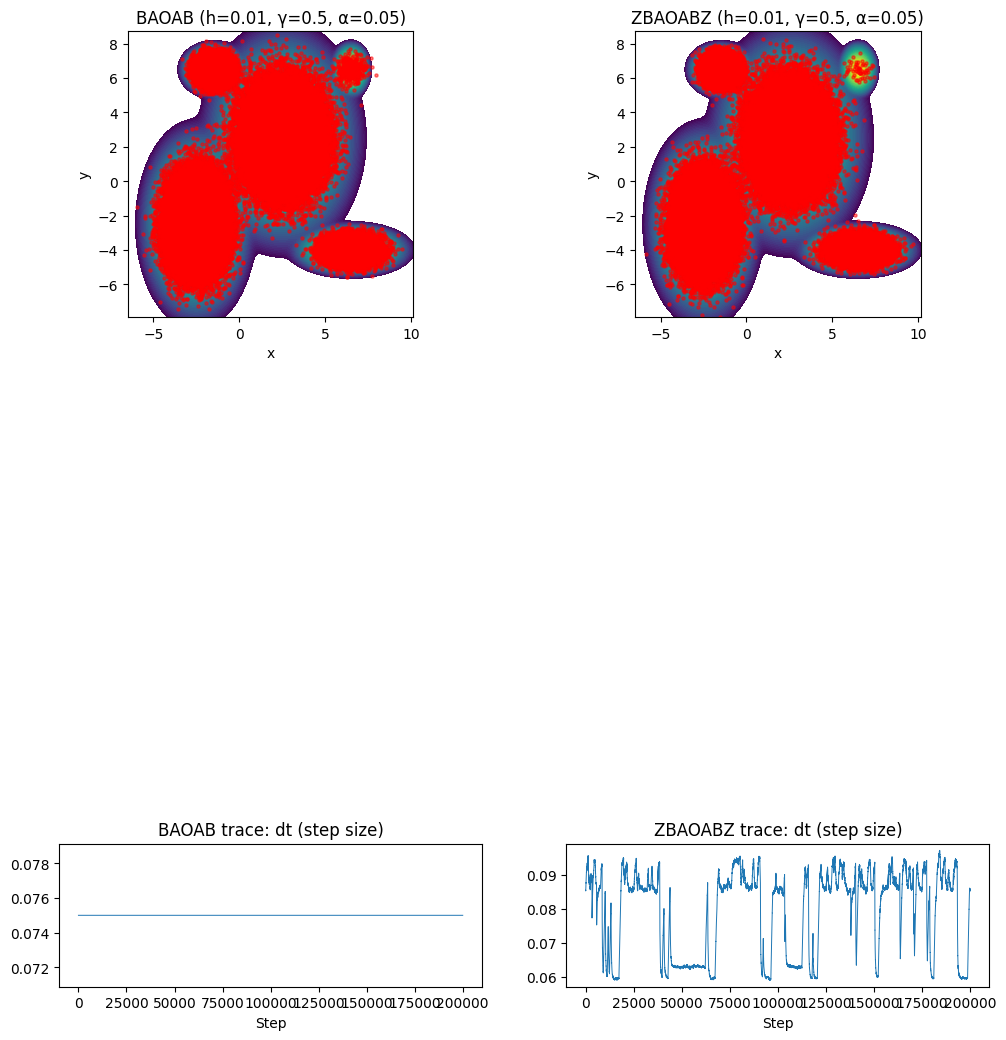

In [1]:
import numpy as np
from numba import njit
from ipywidgets import interact, FloatLogSlider
from viz import plot_samplers, plot_samplers_first_order
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import fixed

# ====================================================
# 2D Gaussian Mixture Model (GMM)
# ====================================================

# Define mixture components
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # mixture weights (sum to 1)
means = np.array([
    [- 2.5, - 2.5],    # mode 1
    [6.5,  6.5],       # mode 2
    [-1.5,  6.5],      # mode 3
    [6.5,  - 4.0],     # mode 4
    [2.5,  2.5]        # mode 5
])
covs = np.array([
    [[0.5, 0.], [0., 1.5]],
    [[0.05, 0.0], [0.0, 0.1]],
    [[0.15, 0.0], [0.0, 0.1]],
    [[0.5, 0.0], [0.0, 0.1]],
    [[1.0, 0.0], [0.0, 2.0]]
])
inv_covs = np.linalg.inv(covs)
det_covs = np.array([np.linalg.det(c) for c in covs])

# ====================================================
# Gradient of potential energy U = - log p
# ====================================================
@njit
def grad_U(z):
    y, x = z
    p_total = 0.0
    grad_total = np.zeros(2)
    for i in range(len(weights)):
        diff = np.array([x - means[i][0], y - means[i][1]])
        coef = weights[i] * np.exp(- 0.5 * diff @ inv_covs[i] @ diff) / np.sqrt((2 * np.pi) ** 2 * det_covs[i])
        p_total += coef
        grad_total += coef * (inv_covs[i] @ diff)

    return np.flip(grad_total) / max(p_total, 1e-16)

# ====================================================
# Log target density (for contours)
# ====================================================
def log_p(y, x):
    pts = np.stack([x, y], axis=-1)
    log_probs = np.zeros(pts.shape[:-1])
    for k in range(len(weights)):
        diff = pts - means[k]
        exponent = - 0.5 * np.sum(diff @ inv_covs[k] * diff, axis=-1)
        log_probs += weights[k] * np.exp(exponent) / np.sqrt((2 * np.pi) ** 2 * det_covs[k])
    return np.log(log_probs + 1e-16)

# ====================================================
# Plot setup
# ====================================================
xs = np.linspace(-20, 20, 400)
ys = np.linspace(-20, 20, 400)
X, Y = np.meshgrid(xs, ys)
LOGZ = log_p(Y, X)
vmax, vmin = LOGZ.max(), LOGZ.max() - 15
levels = np.linspace(vmin, vmax, 50)

# sampler parameters
m, M, r, s = 0.5, 50, 0.25, 2
b = 7.5  # BAOAB stepsize multiplier
burnin = int(1e4)
nsteps = int(1e6)  # start smaller for debugging

# ====================================================
# Run and visualize
# ====================================================
# plot_samplers(
#     alpha=0.05,
#     h=0.01,
#     gamma=0.5,
#     beta=1.0,
#     grad_U=grad_U,
#     X=X,
#     Y=Y,
#     LOGZ=LOGZ,
#     levels=levels,
#     m=m,
#     M=M,
#     r=r,
#     s=s,
#     b=b,
#     burnin=burnin,
#     nsteps=nsteps,
#     record_trace=True,
#     plot_stride=5)

plot_samplers_first_order(
    alpha=0.05,
    h=0.01,
    gamma=0.5,
    beta=1.0,
    grad_U=grad_U,
    X=X,
    Y=Y,
    LOGZ=LOGZ,
    levels=levels,
    m=m,
    M=M,
    r=r,
    s=s,
    b=b,
    burnin=burnin,
    nsteps=nsteps,
    record_trace=True,
    plot_stride=5)
